# Experiment: Varying N in top-N DDA fragmentation

We demonstrate that the simulator can be used for scan-level closed-loop DDA experiments. 
- Take an existing data. Find out which MS1 peaks are linked to which MS2 peaks.
- Run all MS1 peaks through the simulator’s Top-N protocol. 
- If N is greater than the real data, do we see the same MS1 peaks from (1) being fragmented again, plus additional fragment peaks?
- Can we use the simulator to find a new N that maximises the number of MS1 peaks being fragmented?
- Verification on actual machine.
- Talk to stefan about machine time.

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [73]:
import numpy as np
import pandas as pd
import sys
import scipy.stats
import pylab as plt
from IPython import display
import pylab as plt
from random import random, shuffle

In [4]:
sys.path.append('../codes')

In [48]:
from VMSfunctions.Chemicals import *
from VMSfunctions.Chromatograms import *
from VMSfunctions.MassSpec import *
from VMSfunctions.Controller import *
from VMSfunctions.Common import *
from VMSfunctions.DataGenerator import *
from VMSfunctions.Noise import *

### Load densities trained on 4 beer data (see [loader_kde](loader_kde.ipynb)).

In [6]:
ps = load_obj('../models/peak_sampler_4_beers.p')

### Load chromatogram data exported from the real data (BEER1POS)

In [7]:
xcms_output = '../models/beer1pos_ms1_peaks.csv.gz'
cc = ChromatogramCreator(xcms_output)

DEBUG:Chemicals:Loading 0 chromatograms
../codes\VMSfunctions\Common.py:56: RuntimeWarning:

divide by zero encountered in double_scalars

DEBUG:Chemicals:Loading 5000 chromatograms
DEBUG:Chemicals:Loading 10000 chromatograms


In [8]:
min_ms1_intensity = 2E5
min_rt = 3*60
max_rt = 21*60
chemicals = ChemicalCreator(ps)
dataset = chemicals.sample_from_chromatograms(cc, min_rt, max_rt, min_ms1_intensity, ms_levels=2)

DEBUG:Chemicals:11340 ms1 peaks to be created.
DEBUG:Chemicals:i = 0
DEBUG:Chemicals:i = 2500
DEBUG:Chemicals:i = 5000


In [9]:
len(dataset)

5821

### Add noise

Create region of interest objects

In [10]:
mzml_path = 'C:\\Users\\joewa\\University of Glasgow\\Vinny Davies - CLDS Metabolomics Project\\Data\\Beers_4Beers_compared\\Positive\\samples\\mzML'
roi_file = 'C:\\Users\\joewa\\University of Glasgow\\Vinny Davies - CLDS Metabolomics Project\\Data\\Beers_4Beers_compared\\rois.csv'

ds = DataSource()
ds.load_data(mzml_path)
ds.extract_roi(roi_file)

INFO:DataGenerator:Loading Beer_1_full1.mzML
INFO:DataGenerator:Loading Beer_1_full2.mzML
INFO:DataGenerator:Loading Beer_1_full3.mzML
INFO:DataGenerator:Loading Beer_2_full1.mzML
INFO:DataGenerator:Loading Beer_2_full2.mzML
INFO:DataGenerator:Loading Beer_2_full3.mzML
INFO:DataGenerator:Loading Beer_3_full1.mzML
INFO:DataGenerator:Loading Beer_3_full2.mzML
INFO:DataGenerator:Loading Beer_3_full3.mzML
INFO:DataGenerator:Loading Beer_QC_full1.mzML
INFO:DataGenerator:Loading Beer_QC_full2.mzML
INFO:DataGenerator:Loading Beer_QC_full3.mzML
INFO:DataGenerator:Creating ROI objects for Beer_1_full1.mzML
DEBUG:DataGenerator:     0/394970
DEBUG:DataGenerator: 50000/394970
DEBUG:DataGenerator:100000/394970
DEBUG:DataGenerator:150000/394970
DEBUG:DataGenerator:200000/394970
DEBUG:DataGenerator:250000/394970
DEBUG:DataGenerator:300000/394970
DEBUG:DataGenerator:350000/394970
INFO:DataGenerator:Populating ROI objects for Beer_1_full1.mzML
DEBUG:DataGenerator:     0/  1112 processing spectrum <__ma

In [14]:
filename = list(ds.all_rois.keys())[0]

In [15]:
filename

'Beer_1_full1.mzML'

Add a whole bunch of `UnknownChemicals` with chromatograms coming from non-peak ROIs from Beer1Pos

In [35]:
nc = NoisyRoiCreator(ps, ds, filename)

In [57]:
len(nc.false_rois)

316830

In [ ]:
save_obj(nc, '../models/top_n_nc.p')

Added 9000 small non-peaks regions of interests

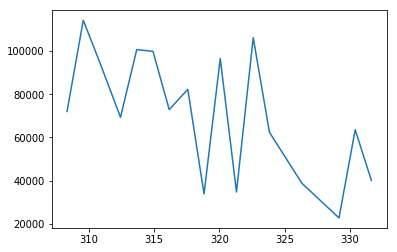

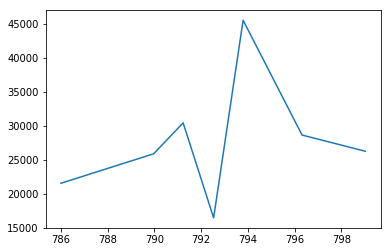

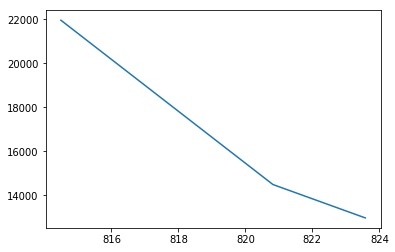

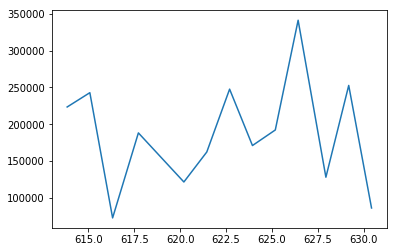

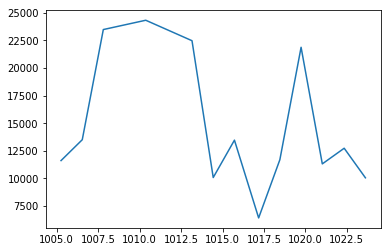

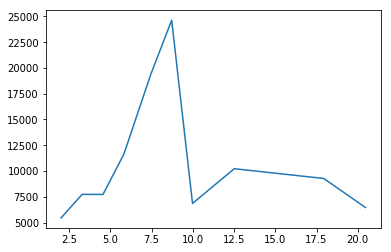

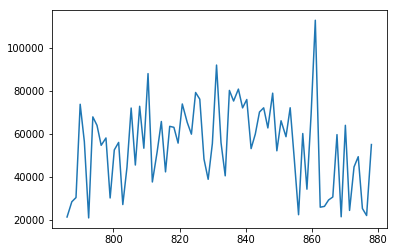

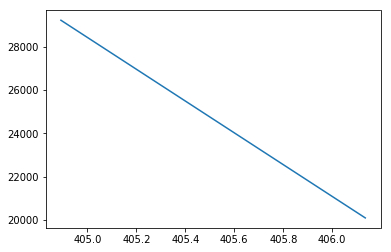

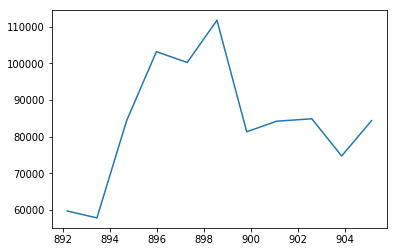

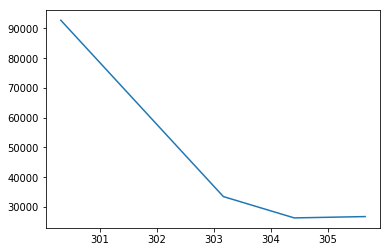

In [142]:
noises = nc.sample(9000, ms_levels=2, min_num_scans=5)
for c in noises[0:10]:
    chrom = c.chromatogram
    plt.plot(chrom.raw_rts, chrom.raw_intensities)
    plt.show()

Add 1000 large non-peaks regions of interest

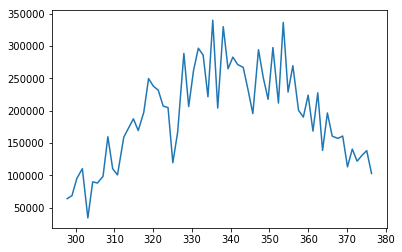

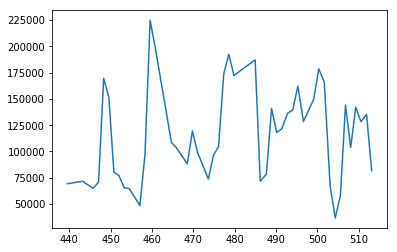

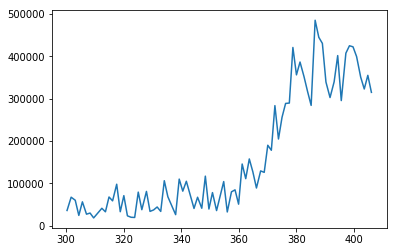

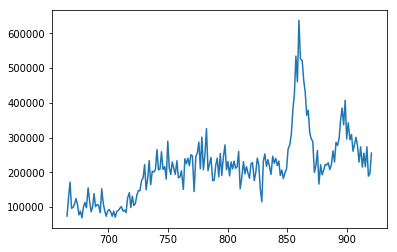

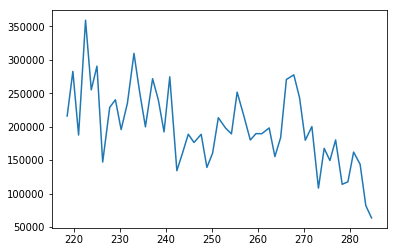

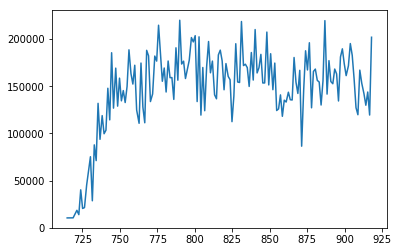

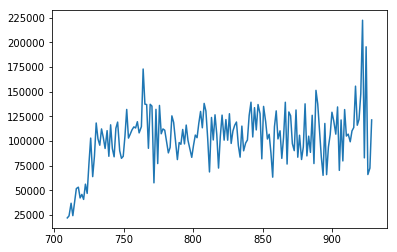

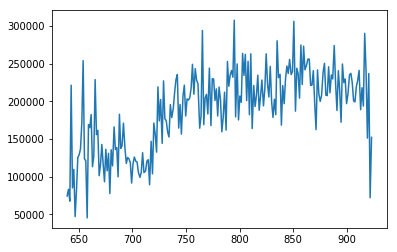

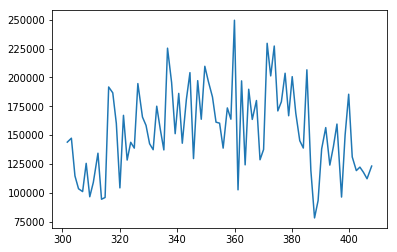

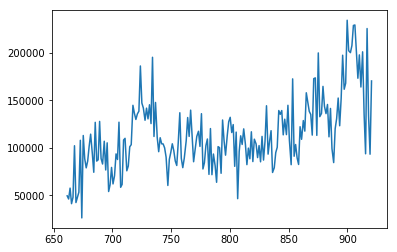

In [131]:
large_noises = nc.sample(1000, ms_levels=2, min_num_scans=50, 
                         min_rt=min_rt, max_rt=max_rt, min_ms1_intensity=min_ms1_intensity)
for c in large_noises[0:10]:
    chrom = c.chromatogram
    plt.plot(chrom.raw_rts, chrom.raw_intensities)
    plt.show()

In [147]:
noisy_dataset = dataset + noises + large_noises

In [148]:
shuffle(noisy_dataset)

In [149]:
len(dataset)

5821

In [150]:
len(noisy_dataset)

15821

### Set up a Top-N controller

In [155]:
N = 10                   # top-5 DDA fragmentation
isolation_window = 0.5   # the isolation window in Dalton around a selected precursor ion
rt_tol = 5               # the rt window around a selected precursor ion to prevent it from fragmented multiple times
min_ms2_intensity = 5000 # the minimum ms2 peak intensity

In [156]:
mass_spec = IndependentMassSpectrometer(POSITIVE, noisy_dataset, density=ps.density_estimator)
controller = TopNController(mass_spec, N, isolation_window, rt_tol, min_ms2_intensity=min_ms2_intensity)

In [178]:
set_log_level_warning()
# set_log_level_info()
# set_log_level_debug()

controller.make_plot = False

In [158]:
controller.run(min_rt, max_rt)

In [159]:
controller.write_mzML('my analysis', '../models/noisy_top_10.mzML')

### Experiment by varying N

In [ ]:
controllers = []
for N in range(5, 51, 5):
    print('N =', N)
    analysis_name = 'Top-%d Analysis' % N
    outfile = '../models/noisy_top_%d.mzML' % N
    
    mass_spec = IndependentMassSpectrometer(POSITIVE, noisy_dataset, density=ps.density_estimator)
    controller = TopNController(mass_spec, N, isolation_window, rt_tol, min_ms2_intensity=min_ms2_intensity)
    controller.run(min_rt, max_rt)
    controller.write_mzML(analysis_name, outfile)
    controllers.append(controller)

Plot total number of fragmented MS2 peaks

In [ ]:
def get_total_peaks(controller, ms_level):
    num_peaks = [scan.num_peaks for scan in controller.scans[ms_level]]
    return sum(num_peaks)

In [ ]:
total_peaks = [get_total_peaks(controller, 2) for controller in controllers]
plt.plot(total_peaks)
plt.xlabel('N')
plt.ylabel('Total MS2 Peaks')
plt.title('Top-N vs Total MS2 Peaks')

Plot how many large MS1 peaks got fragmented

In [203]:
sorted_dataset = sorted(dataset, key=lambda x: x.max_intensity, reverse=True)
most_intense = sorted_dataset[0:100]